In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
import json
import os
import pandas as pd
import matplotlib.dates as mdates

In [10]:
%cd ..

f:\ProjectSolar\ProjectSolar-20240704_v0


In [11]:
config_path = 'data/Heino_test/output_20240913_225349/config.json'
# ground_truth_path = 'data/TUDelft/measured_data.csv'


In [12]:
with open(config_path, 'r') as file:
    CONFIG = json.load(file)
    print(CONFIG)

{'area_per_point': 9, 'azimuth_resolution': 5, 'elevation_resolution': 5, 'epw_file': 'heino.epw', 'global_irradiance_time': 1834.2714636325836, 'irradiance_batch_size': 500, 'irradiance_model': 'isotropic', 'num_bounces': 2, 'output_folder_name': 'output_20240913_225349', 'result': {'bbox_max': [215605.0, 495792.5, 17.389999389648438], 'bbox_min': [212940.0, 493127.5, 1.1240005493164062], 'global_irradiance_time': 4675.882308006287, 'num_timesteps': 12, 'shadow_calculation_time': 0.14721819758415222, 'viewshed_rendering_time': 44.666961669921875, 'voxel_dim_x': 297, 'voxel_dim_y': 297, 'voxel_dim_z': 2}, 'scenario': 'weatherstation', 'study_area': {'data_root': './data/Heino_test', 'end_time': '2019-09-23 00:00:00', 'frequency': 'h', 'lat': 52.43393735045974, 'long': 6.261741696877466, 'start_time': '2019-09-22 00:00:00', 'timezone': 'Europe/Amsterdam'}, 'voxel_resolution': 9}


In [13]:
folder_path = CONFIG['study_area']['data_root']
data_root = os.path.join(folder_path, CONFIG['output_folder_name'])
point_grid_path = os.path.join(data_root, 'intermediate', 'point_grid.dat')
index_map_path = os.path.join(data_root,  'index_map.dat')
shadow_map_path = os.path.join(data_root, 'shadow_map.dat')
sun_pos_path = os.path.join(data_root, 'intermediate', 'sun_pos.csv')


horizon_factor_path = os.path.join(data_root, 'horizon_factor_map.dat')
sky_view_factor_path = os.path.join(data_root,  'sky_view_factor_map.dat')
cosine_map_path = os.path.join(data_root, 'cosine_map.dat')

voxel_size = CONFIG['voxel_resolution']
num_azimuth = 360//CONFIG['azimuth_resolution']
num_elevation = 90//CONFIG['elevation_resolution']
print(num_azimuth, num_elevation)
num_samples = num_azimuth*num_elevation
index_dim = (num_elevation,num_azimuth)

estimated_irradiance_path = os.path.join(data_root, 'irradiance.npy')
simplified_irradiance_path = os.path.join(data_root, 'simplified_irradiance.npy')
weather_data_path = os.path.join(data_root, 'weather_data.npy')

point_grid = np.loadtxt(point_grid_path)
estimated_irradiance = np.load(estimated_irradiance_path)
simplified_irradiance = np.load(simplified_irradiance_path)
weather_data = np.load(weather_data_path)
solar_positions = pd.read_csv(sun_pos_path)

72 18


In [32]:
total_areas_path = os.path.join(data_root, 'triangle_areas.dat')
total_areas = np.fromfile(total_areas_path,dtype=np.float64)
filtered_areas = total_areas[total_areas <= 100]

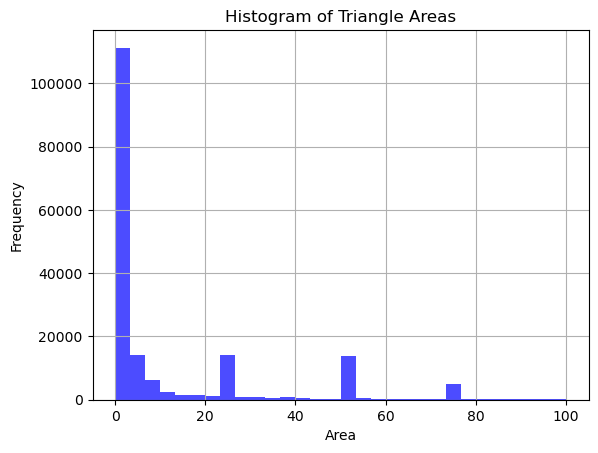

In [35]:
plt.hist(filtered_areas, bins=30, color='blue', alpha=0.7)  # bins参数控制直方图的柱子数量
plt.title('Histogram of Triangle Areas')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(f"./data/figures/Heino_areas.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [47]:
def print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, point_idx):
    horizon_factor_path = np.memmap(horizon_factor_path, dtype=np.float16, mode='r')
    sky_view_factor_path = np.memmap(sky_view_factor_path, dtype=np.int32, mode='r')
    index_map = np.memmap(index_map_path, dtype=np.uint32, mode='r')
    # cosine_map = np.memmap(cosine_map_path, dtype=np.float16, mode='r')

    num_samples = index_dim[0]*index_dim[1]
    index_start = point_idx*num_samples
    index_end = (point_idx+1)*num_samples

    voxel_indices = index_map[index_start:index_end]
    # breakpoint()
    voxel_indices = voxel_indices.reshape(index_dim)
    unique_values = np.unique(voxel_indices)

    # sum_of_cosine = np.sum(cosine_map[index_start*6:index_end*6])
    # print("sum of cosine: ", sum_of_cosine)

    # 创建一个随机颜色映射，确保白色为最大值对应的颜色
    colors = {}
    for value in unique_values:
        # print(value)
        if value == 4294967295:
            colors[value] = (1.0, 1.0, 1.0)  # 白色
        else:
            colors[value] = (random.random(), random.random(), random.random())

    # 将图像数据转换为 RGB
    image = np.zeros((voxel_indices.shape[0], voxel_indices.shape[1], 3))

    for i in range(voxel_indices.shape[0]):
        for j in range(voxel_indices.shape[1]):
            image[i, j] = colors[voxel_indices[i, j]]

    # image = np.flipud(image)
    plt.xticks(np.linspace(0, voxel_indices.shape[1] - 1, num=5), 
           labels=np.linspace(0, 360, num=5).astype(int))  # 横轴 azimuth 从 0 到 360 度

    plt.yticks(np.linspace(0, voxel_indices.shape[0] - 1, num=4), 
            labels=np.linspace(90, 0, num=4).astype(int))  # 纵轴 elevation 从 0 到 90 度

    # 添加坐标轴标签
    plt.xlabel('Azimuth (degrees)')
    plt.ylabel('Elevation (degrees)')

    plt.imshow(image)
    # plt.savefig('S3.png', bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.axis('off')  # 隐藏坐标轴
    plt.show()

    print("sky view factor: ", sky_view_factor_path[point_idx]/num_samples)
    print("horizon factor: ", horizon_factor_path[point_idx])
    formatted_values = [f"{x:.5f}" for x in point_grid[point_idx]]
    print("point info: ", formatted_values)

    



In [48]:
def calculate_metrics(y_true, y_pred):
    # 计算均值
    mean_y_true = np.mean(y_true)
    
    # Pearson Correlation Coefficient
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    
    # nMBE (normalized Mean Bias Error)
    mbe = np.mean(y_pred - y_true)
    nMBE = mbe / mean_y_true
    
    # nMAE (normalized Mean Absolute Error)
    mae = np.mean(np.abs(y_pred - y_true))
    nMAE = mae / mean_y_true
    
    # nRMSE (normalized Root Mean Squared Error)
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    nRMSE = rmse / mean_y_true
    
    return correlation, nMBE, nMAE, nRMSE

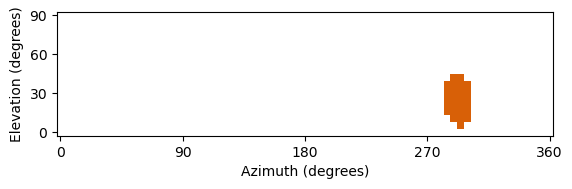

sky view factor:  0.9799382716049383
horizon factor:  0.0
point info:  ['214283.79688', '494443.09375', '5.05800', '0.00000', '0.00000', '1.00000', '0.10000', '2.00000', '1539012.00000', '9612.00000']


In [49]:
# s1_idx = 1119236 # s1
# s2_idx = 1130787 # s2
sensor_idx = 1539012
print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, sensor_idx)
# print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, s2_idx)

In [50]:
def obtain_weatherstation(weather_data, sunpos_filename):
    sunpos = pd.read_csv(sunpos_filename)
    sunpos.columns.values[0]='local_time'
    sunpos['local_time'] = pd.to_datetime(sunpos['local_time']).dt.tz_localize(None)
    sunpos['GHI'] = weather_data[:,0]
    
    return sunpos

In [51]:
ground_measurement = obtain_weatherstation(weather_data, sun_pos_path)

In [52]:
def plot_irradiance(ground_measurement, estimated_irradiance, simplified_irradiance, s1_idx):
    plt.figure(figsize=(12, 8))
    ground_measurement['local_time'] = pd.to_datetime(ground_measurement['local_time'])
    first_datetime_str = ground_measurement.loc[0, 'local_time']

# 转换为日期时间对象并提取日期部分
    first_date = pd.to_datetime(first_datetime_str).date()
    time_formatter = mdates.DateFormatter('%H:%M')

    for i in range(3):
        # plt.plot(estimated_irradiance[i][s1_idx], label=f"Bounce {i}", marker='o')
        plt.plot(ground_measurement['local_time'], estimated_irradiance[i][s1_idx], label=f"Bounce {i}", marker='o', markersize=2)
        correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['GHI'].values, estimated_irradiance[i][s1_idx])
        print(f"Bounce {i} correlation: {correlation:.4f}, nMBE: {nMBE:.4f}, nMAE: {nMAE:.4f}, nRMSE: {nRMSE:.4f}")

    # simplified_prediction = estimated_irradiance[0][s1_idx] + ground_measurement['GHI'].values * 0.2
    direct_simplified_diffuse_reflect = simplified_irradiance[0][s1_idx] + simplified_irradiance[1][s1_idx] + simplified_irradiance[2][s1_idx]
    direct_simplified_reflect = estimated_irradiance[0][s1_idx] + simplified_irradiance[2][s1_idx]

    correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['GHI'].values, direct_simplified_diffuse_reflect)
    print(f"simplified svf and no global reflective: {correlation:.4f}, nMBE: {nMBE:.4f}, nMAE: {nMAE:.4f}, nRMSE: {nRMSE:.4f}")
    plt.plot(ground_measurement['local_time'], direct_simplified_diffuse_reflect, label="simplified svf and no global reflective", marker='o', markersize=2)

    correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['GHI'].values, direct_simplified_reflect)
    print(f"no global reflective: {correlation:.4f}, nMBE: {nMBE:.4f}, nMAE: {nMAE:.4f}, nRMSE: {nRMSE:.4f}")
    plt.plot(ground_measurement['local_time'], direct_simplified_reflect, label="no global reflective", marker='o', markersize=2)

    plt.plot(ground_measurement['local_time'], ground_measurement['GHI'].values, label="Weatherstation ground measurements", marker='o',markersize=2, linewidth=4, color='#8B0000')
    

    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title("Comparison of Estimated Irradiance and Weather Data")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(time_formatter)
    # plt.xticks(rotation=45)  # Rotate x-axis labels to make them readable
    # plt.tight_layout()
    plt.savefig(f"./data/figures/Heino_{first_date}.png", bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()



Bounce 0 correlation: 0.9912, nMBE: -0.0496, nMAE: 0.0705, nRMSE: 0.0996
Bounce 1 correlation: 0.9912, nMBE: -0.0483, nMAE: 0.0700, nRMSE: 0.0988
Bounce 2 correlation: 0.9912, nMBE: -0.0482, nMAE: 0.0699, nRMSE: 0.0988
simplified svf and no global reflective: 0.9915, nMBE: -0.0355, nMAE: 0.0661, nRMSE: 0.0910
no global reflective: 0.9912, nMBE: -0.0496, nMAE: 0.0705, nRMSE: 0.0996


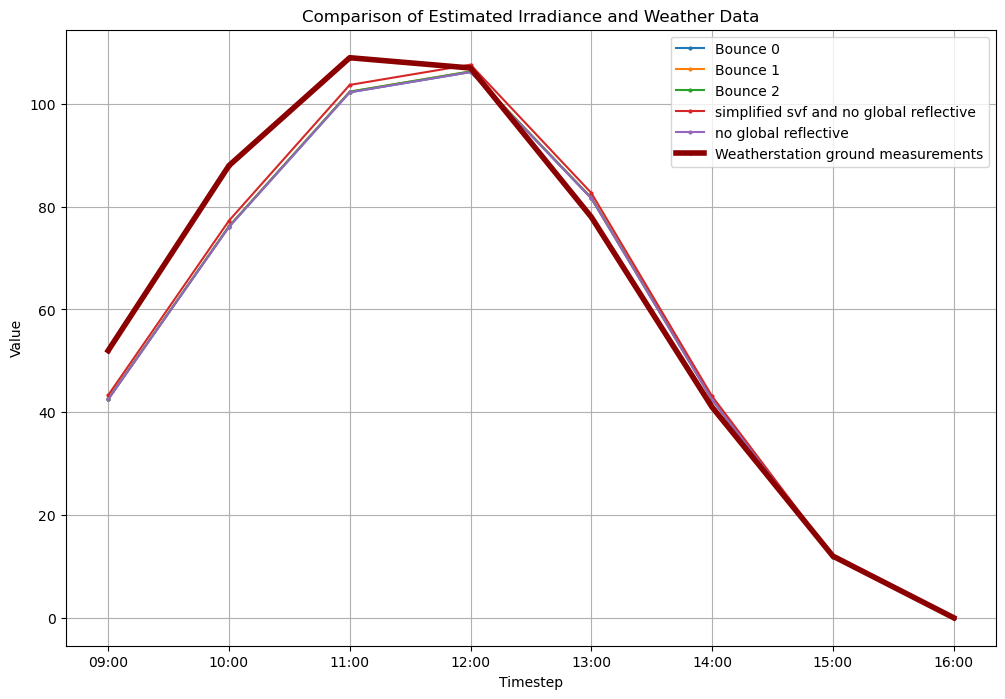

In [53]:
plot_irradiance(ground_measurement, estimated_irradiance, simplified_irradiance, sensor_idx)

In [54]:
# plot_irradiance(ground_measurement, estimated_irradiance, s1_idx, s2_idx)